In [53]:

from emg_functions import *
import emg_functions
print(emg_functions.__file__)
import importlib
import imu_functions
from imu_functions import *
print(imu_functions.__file__)

/Users/beatrizfigueiredo/Documents/Project-course-CM2024/emg_functions.py
/Users/beatrizfigueiredo/Documents/Project-course-CM2024/imu_functions.py


...
Applying filter
...
Retrieving the muscle time activations from the punches
...
Number of punches Arm: 10
Number of punches Chest: 22
-------------------------------
Muscle time activation for arm:
[0.12, 0.135, 0.105, 0.165, 0.105, 0.285, 0.15, 0.15, 0.12, 0.24]
Muscle time activation for chest:
[0.06, 0.18, 0.045, 0.045, 0.12, 0.045, 0.165, 0.075, 0.045, 0.09, 0.075, 0.21, 0.3, 0.045, 0.21, 0.045, 0.045, 0.135, 0.075, 0.045, 0.045, 0.33]
-------------------------------


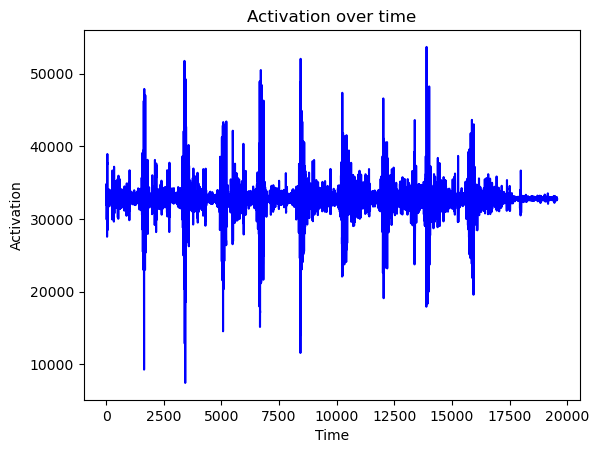

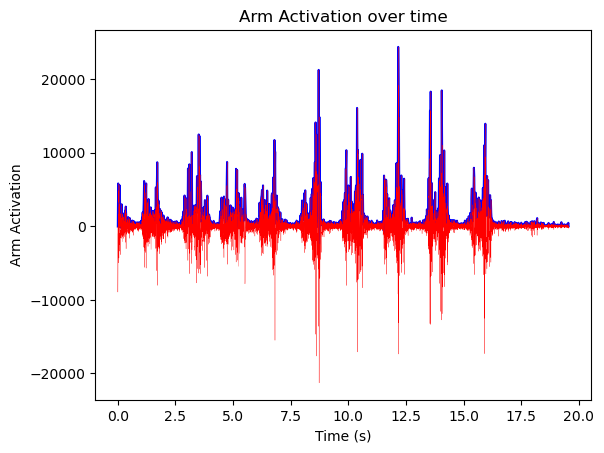

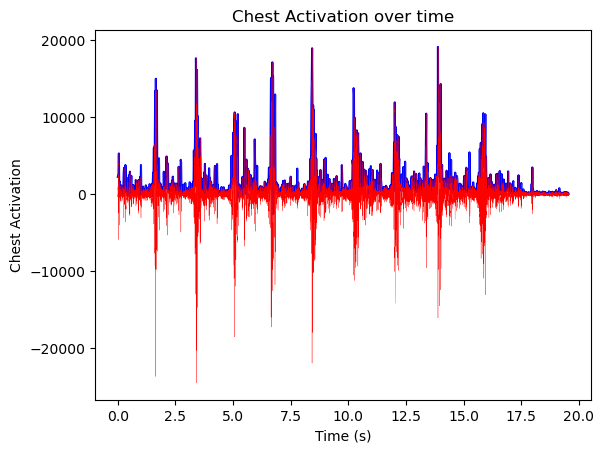

In [52]:
'''emgFilePath = './data/18oct/ioanna_hook.txt'#'./data/18oct/Lorenzo_hook.txt'#'./data/EMG_data/saffie_hook.txt'#'opensignals_0007804b3c23_2024-09-09_15-04-53.txt'
#--- manuell open (in pipeline)
#Open and reads the file with the EMG data to a long text string and saves it to rawData. Closes the file at the end.
with open(emgFilePath, 'r') as file:     
    rawData = file.read()      
    file.close
    pass        
#---'''
rawData = select_emg_file()
signalThreshold = 40000
sampleRate = get_sample_rate(rawData)


dataWithHeader = get_emg_data(rawData,sampleRate)
timeAdjustedEmg = find_first_punch(dataWithHeader,signalThreshold) #adjusted data is [time:EMG data Arm, EMG data chest]

emgDataArm = []
emgDataChest = []
timeValues = []
for row in timeAdjustedEmg:
    timeValues.append(row[0])
    emgDataArm.append(row[1])
    emgDataChest.append(row[2])
print("Collecting data from file")
print("...")
#filterdSignal = find_first_punch(dataTable, threshold)
lowcut = 20
highcut = 450
adjustedEmgArm = apply_filter(emgDataArm, lowcut, highcut, sampleRate) # adjustedEmg = filteredSignal
adjustedEmgChest = apply_filter(emgDataChest, lowcut, highcut, sampleRate)
print("Applying filter")
print("...")
window = 15 # ella jab = 11   bea_hook = 15
diffThreashold = 6 #for lorenzo_jab:6   lorenzo_hook:5   ioanna_jab:11   ioanna_hook:4    ella_jab:6   ella_hook:4   bea_jab:7   bea_hook:6
diffThreasholdChest = 2 #for lorenzo_jab:2   lorenzo_hook:N/A   ioanna_jab:2   ioanna_hook:N/A   ella_jab: N/A   ella_hook:N/A   bea_jab:N/A   bea_hook:N/A
envelopeValuesArm,timeValuesEnvelopeArm = envelope_emg(adjustedEmgArm,window,sampleRate)
envelopeValuesChest,timeValuesEnvelopeChest = envelope_emg(adjustedEmgChest,window,sampleRate)
zoomThreshold = 2000 #ioanna_hook:3100   ella_jab:2500 ella_hook:1500
zoomThresholdChest = 2000
print("Retrieving the muscle time activations from the punches")
print("...")

muscleActivationTimeArm = get_muscle_time(envelopeValuesArm,zoomThreshold,window,sampleRate,diffThreashold)
print(f"Number of punches Arm: {len(muscleActivationTimeArm)}")
muscleActivationTimeChest = get_muscle_time(envelopeValuesChest,zoomThresholdChest,window,sampleRate,diffThreasholdChest)
print(f"Number of punches Chest: {len(muscleActivationTimeChest)}")
print('-------------------------------')
print('Muscle time activation for arm:')
print(muscleActivationTimeArm)
print('Muscle time activation for chest:')
print(muscleActivationTimeChest)
print('-------------------------------')

plt.plot(emgDataChest, "b")
#plt.plot(timeValues,adjustedEmgArm, "r", lw = 0.2) 
plt.xlabel('Time')
plt.ylabel('Activation')
plt.title('Activation over time')
plt.show()

plt.plot(timeValuesEnvelopeArm, envelopeValuesArm, "b")
plt.plot(timeValues,adjustedEmgArm, "r", lw = 0.2) 
plt.xlabel('Time (s)')
plt.ylabel('Arm Activation')
plt.title('Arm Activation over time')
plt.show()

plt.plot(timeValuesEnvelopeChest, envelopeValuesChest, "b")
plt.plot(timeValues,adjustedEmgChest, "r", lw = 0.2) 
plt.xlabel('Time (s)')
plt.ylabel('Chest Activation')
plt.title('Chest Activation over time')
plt.show()

Number of Punches: 10 -> [229.74673332323493, 211.9845663297484, 247.5604203564211, 261.691463934612, 261.691463934612, 261.691463934612, 261.691463934612, 229.40824991194694, 261.691463934612, 261.691463934612]


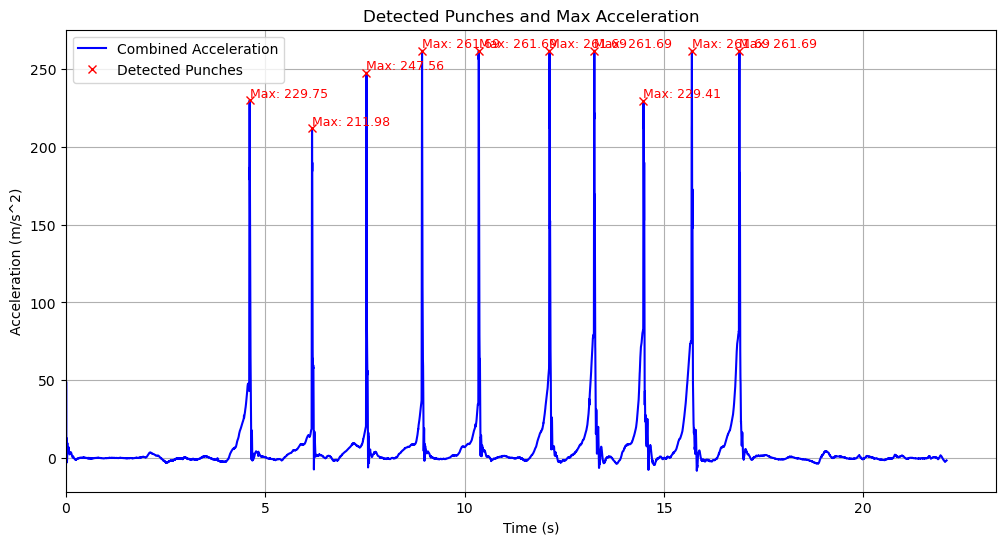

In [12]:
#Set threashold for zacc where timestamp starts, from calibration
threshold=10

# List to store the timestamps and data
timestampsAcc = []
xAcc = []
yAcc = []
zAcc = []
acc = []

# Read, extract, and process accelerometer data
jsonDataAcc = read_json_file()
timestampsAcc, xAcc, yAcc, zAcc = extract_acc_data(jsonDataAcc)

# Adjust timestamps to start from the first time Z-acceleration exceeds the threshold
adjustedTimestamps = adjust_timestamps_on_first_threshold(timestampsAcc, zAcc, threshold)


# Calculate the acceleration
acc = calculate_acceleration(xAcc, yAcc, zAcc)

# Detect punches and their max accelerations
window_size=20 #if all punches are not showing, it means we have to reduce the window_size
punch_peaks, max_accelerations, peak_timestamps = detect_punches_and_max_acc(adjustedTimestamps, acc, window_size)

# Print max acceleration values as an array for further use
print(f"Number of Punches: {len(max_accelerations)} -> {max_accelerations}")

# # Output the max accelerations and timestamps
# for i, max_acc in enumerate(max_accelerations):
#     print(f"Punch {i+1}: Max Acceleration = {max_acc:.2f} m/s^2 in the time window ({peak_timestamps[i]}s).")


# Plot the punches and max accelerations
plot_punches_with_max_acc(adjustedTimestamps, acc, punch_peaks, max_accelerations, peak_timestamps)

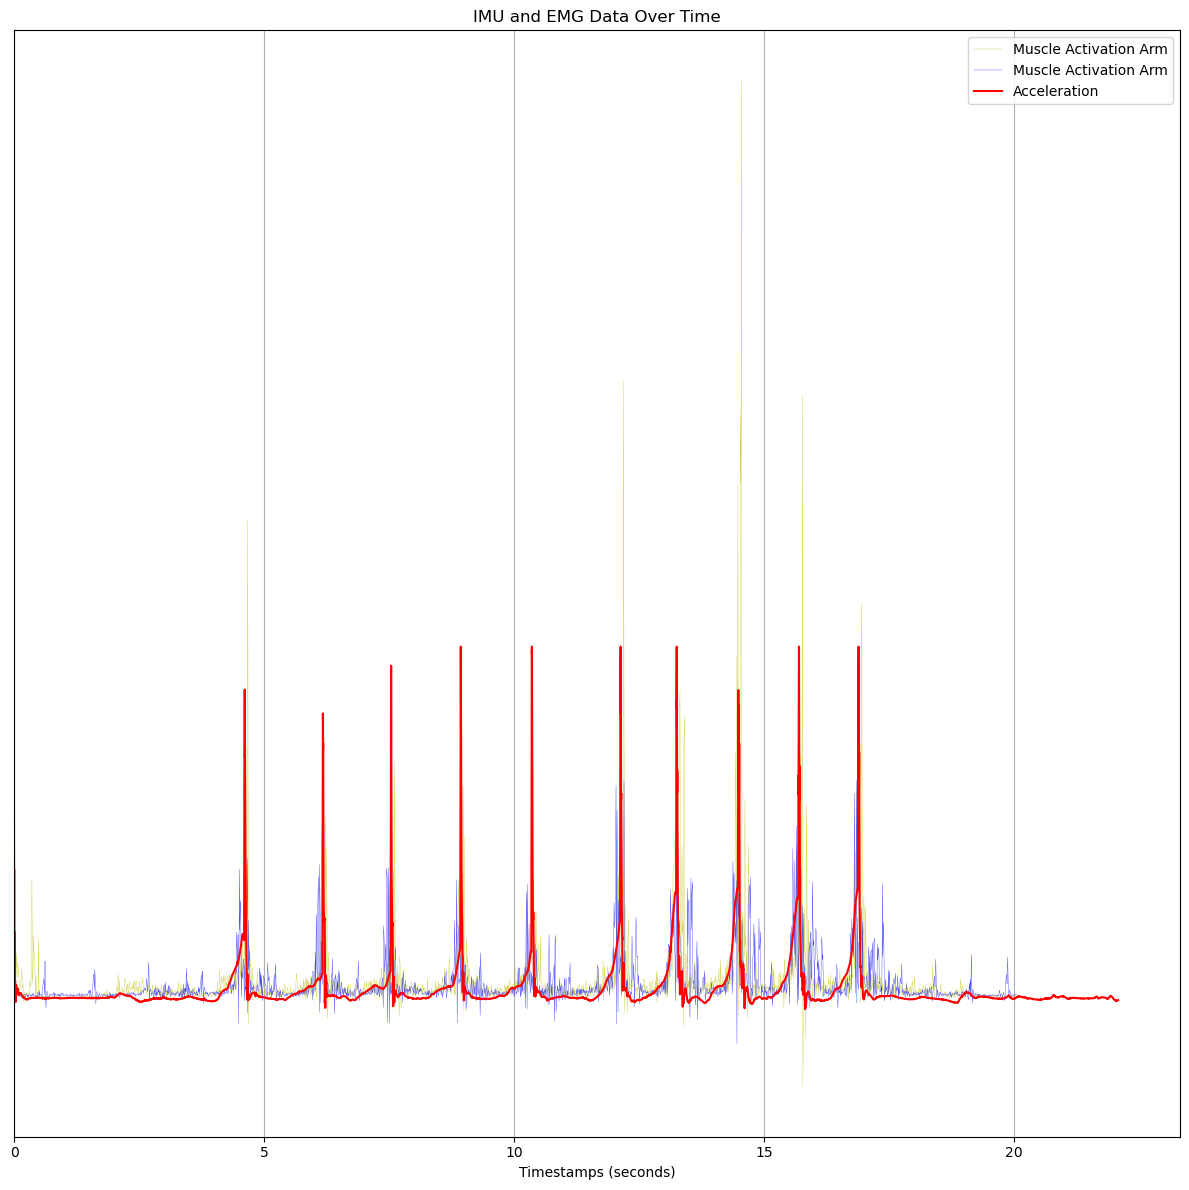

In [16]:
#Code to plot both data in one graph
plt.figure(figsize=(12, 12))

# Convert acc to a NumPy array if it's not already
acc = np.array(acc)

# Multiply each element of acc by 1000
acc_scaled = acc * 50

# plt.subplot(3, 1, 1)
plt.plot(timeValuesEnvelopeArm, envelopeValuesArm, "y", label='Muscle Activation Arm', lw = 0.2)
plt.plot(timeValuesEnvelopeChest, envelopeValuesChest, "b", label='Muscle Activation Arm', lw = 0.2)
plt.plot(adjustedTimestamps, acc_scaled, label='Acceleration', color='r')
plt.xlabel('Timestamps (seconds)')
plt.yticks([]) # Remove the y-axis labels
plt.title('IMU and EMG Data Over Time')
plt.legend()
plt.grid(True)
plt.xlim(left=0)

# Show the plot
plt.tight_layout()
plt.show()

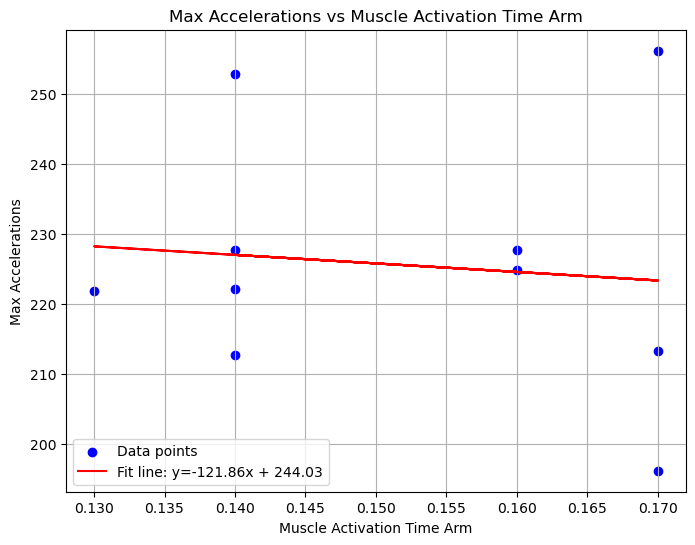

Linear regression equation: y = -121.86x + 244.03
Correlation coefficient (R^2): 0.01


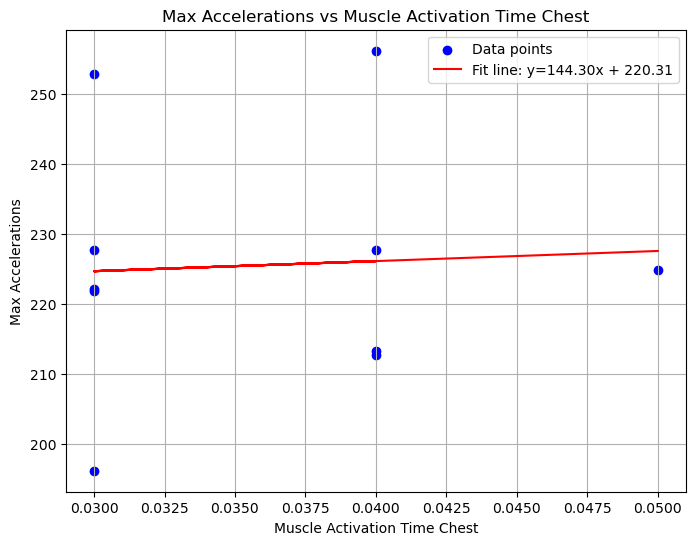

Linear regression equation: y = 144.30x + 220.31
Correlation coefficient (R^2): 0.00


In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Check if lists have the same length
if len(max_accelerations) != len(muscleActivationTimeArm):
    print("Error: The lists 'max_accelerations' and 'muscleActivationTimeArm' must have the same length.")
else:
    # Plot the data
    plt.figure(figsize=(8, 6))
    plt.scatter(muscleActivationTimeArm, max_accelerations, color='blue', label='Data points')
    
    # Step 3: Linear regression to find the correlation/equation
    slope, intercept, r_value, p_value, std_err = stats.linregress(muscleActivationTimeArm, max_accelerations)
    
    # Create regression line values
    regression_line = [slope * x + intercept for x in muscleActivationTimeArm]
    
    # Plot the regression line
    plt.plot(muscleActivationTimeArm, regression_line, color='red', label=f'Fit line: y={slope:.2f}x + {intercept:.2f}')
    
    # Step 4: Customize the plot
    plt.title('Max Accelerations vs Muscle Activation Time Arm')
    plt.xlabel('Muscle Activation Time Arm')
    plt.ylabel('Max Accelerations')
    plt.legend()
    plt.grid(True)
    
    # Show plot
    plt.show()
    
    # Print correlation info
    print(f'Linear regression equation: y = {slope:.2f}x + {intercept:.2f}')
    print(f'Correlation coefficient (R^2): {r_value**2:.2f}')

    # Check if lists have the same length
if len(max_accelerations) != len(muscleActivationTimeChest):
    print("Error: The lists 'max_accelerations' and 'muscleActivationTimeChest' must have the same length.")
else:
    # Plot the data
    plt.figure(figsize=(8, 6))
    plt.scatter(muscleActivationTimeChest, max_accelerations, color='blue', label='Data points')
    
    # Step 3: Linear regression to find the correlation/equation
    slope, intercept, r_value, p_value, std_err = stats.linregress(muscleActivationTimeChest, max_accelerations)
    
    # Create regression line values
    regression_line = [slope * x + intercept for x in muscleActivationTimeChest]
    
    # Plot the regression line
    plt.plot(muscleActivationTimeChest, regression_line, color='red', label=f'Fit line: y={slope:.2f}x + {intercept:.2f}')
    
    # Step 4: Customize the plot
    plt.title('Max Accelerations vs Muscle Activation Time Chest')
    plt.xlabel('Muscle Activation Time Chest')
    plt.ylabel('Max Accelerations')
    plt.legend()
    plt.grid(True)
    
    # Show plot
    plt.show()
    
    # Print correlation info
    print(f'Linear regression equation: y = {slope:.2f}x + {intercept:.2f}')
    print(f'Correlation coefficient (R^2): {r_value**2:.2f}')